In [1]:
import os
import re
from pathlib import Path
from dotenv import load_dotenv

from langchain_groq import ChatGroq

# Get environment variables
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated # to construct the agent's state
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add] # operator.add allows us to add messages instead of replacing them when the LLM's output is returned

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState) # initialize a stateful graph
        memory = MemorySaver() # initialize

        graph.add_node("llm", self.call_groq) # Add LLM node
        graph.add_node("action", self.take_action) # Add Tool node
        
        # The edge where the decision to use a tool is made
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        
        # Create edge and set starting point of the graph
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")

        self.graph = graph.compile(checkpointer=memory) # Build graph
        
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

    # Used by the Agent to check if an action exists by checking the last message in the state which is supposed to contain the tool's info
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # Get the LLM's response and update the Agent's State by adding the response to the messages
    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system: messages = [SystemMessage(content=self.system)] + messages
        
        message = self.model.invoke(messages)
        return {'messages': [message]}

    # Search for the tool and use it
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            
            # If tool not found
            if not t['name'] in self.tools: 
                print("\n ....tool name not found in list of tools....")
                result = "bad tool name, retry"  # instruct LLM to retry
            
            # If tool exists, use it
            else:
                result = self.tools[t['name']].invoke(t['args']) 

            # Save the message returned from the tool
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

        print("Back to the model!")
        return {'messages': results}

In [6]:
# Create the tool to be used by the Agent
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool

# Connect to graph
graph = Neo4jGraph()

@tool
def query_graph(query):
  """Requires get_graph_schema to be run before using this function. This function is to Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)

In [10]:
task = "Task: You are a career guide. Your job is to ask me up to 3 questions to uncover my personality traits according to the RAISEC model. You will ask these questions in a conversational flow where you will ask the second question after I answer the first. Once you understand my personality, you will stop asking questions and use a Neo4j database to improve your knowledge on compatible career paths for me. You will query the possible occupation titles that are suitable for my character. At any point, I can ask you questions and you will answer normally, then you will continue your personality test."

goal = "Understand my personality and then suggest suitable career paths. Note: when asking your questions, please number them to keep track of the number of questions asked."

schema_context = f"Here is the graph's schema: {graph.structured_schema}."

property_values = f"Property Values: empty"

query_approach = "Querying approach: You will not use 'LIMIT'. If Property Values: empty, you will not use general queries and will not include 'WHERE' or try to specify property values inside your Cypher code."

output = "Your final output: Interpret all the queried data, choose up to 3 suitable careers for me, list them in bullet points and include a brief explanation of how each path suites my personality. Include Cypher code in your answer."

tone = "Output's tone: Make your output friendly, fun and easy to read."

personal_info = "Personal Info: I love people and I am a good listener. I enjoy observation and analysis. I prefer being with abults rather than with kids and I also have computer programming skills."

reminder = "Reminder: If Property Values: empty, you will not use 'WHERE' or try to specify property values inside your Cypher code. Under no circumstances should you use 'DELETE'. Find the occupations that suite my character."

prompt = f"{task}\ {goal}\ {schema_context}\ {property_values}\ {query_approach}\ {output}\ {tone}\ {personal_info}\ {reminder}"

In [11]:
# Prepare agent and the initial prompt
model = ChatGroq(temperature=0, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
abot = Agent(model, [query_graph], system=prompt)

# Prepare Human message
query = "What will we do today"

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content=query)
for event in abot.graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What will we do today
================================== Ai Message ==================================

Today, we're going to have some fun exploring your personality traits using the RAISEC model. RAISEC stands for Realistic, Artistic, Investigative, Social, Enterprising, and Conventional. We'll go through a few questions, and I'll get to know you better. Then, I'll use a Neo4j database to find some awesome career paths that suit your personality.

Let's get started! Here's your first question:

1. When working on a project, what do you enjoy most: coming up with creative ideas, analyzing data and details, or helping others and working in a team?


In [12]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="I enjoy a balance between creative work, analysis, and teamwork.")
for event in abot.graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I enjoy a balance between creative work, analysis, and teamwork.
================================== Ai Message ==================================

It sounds like you're a versatile person who enjoys a mix of different activities. That's really valuable in many areas of life.

Here's your next question:

2. When interacting with people, do you tend to be more of a reserved listener who observes and thinks before contributing, or are you more of an outgoing, talkative person who enjoys being the center of attention?


In [13]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Reserved listener who observes")
for event in abot.graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Reserved listener who observes
================================== Ai Message ==================================

Being a reserved listener who observes can be a great strength, especially in roles that require careful consideration and thoughtful decision-making.

Here's your next question:

3. When it comes to problem-solving, do you tend to rely more on logical analysis and step-by-step approaches, or do you often rely on your intuition and creative instincts to find innovative solutions?


In [15]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="When problem solving I mostly use intuition with some logic")
for event in abot.graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

When problem solving I mostly use intuition with some logic
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_fy6z)
 Call ID: call_fy6z
  Args:
    query: MATCH (o:Occupation)-[:need_for_personality_trait]->(t:Personality_Trait) RETURN o.title, t.title
Calling: {'name': 'query_graph', 'args': {'query': 'MATCH (o:Occupation)-[:need_for_personality_trait]->(t:Personality_Trait) RETURN o.title, t.title'}, 'id': 'call_fy6z', 'type': 'tool_call'}
Back to the model!
================================= Tool Message =================================
Name: query_graph

[{'o.title': 'School_Psychologists', 't.title': 'Conventional'}, {'o.title': 'Film_and_Video_Editors', 't.title': 'Conventional'}, {'o.title': 'Editors', 't.title': 'Conventional'}, {'o.title': 'Camera_Operators,_Television,_Video,_and_Film', 't.title': 'Conventional'}, {'o.title': 'Disc_J

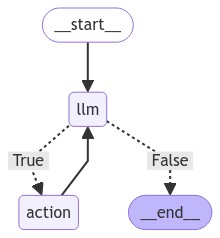

In [69]:
# ## Visualize Graph
from IPython.display import Image

# Image(abot.graph.get_graph().draw_png())
Image(abot.graph.get_graph().draw_mermaid_png(), width=300)
# print(abot.graph.get_graph().draw_ascii())
